In [2]:
# THE CONSUMER PRICE INDEX (CPI) IS A MEASURE OF THE AVERAGE CHANGE OVER TIME IN THE PRICES PAID BY URBAN CONSUMERS FOR A MARKET BASKET OF CONSUMER GOODS AND SERVICES.
# IN THIS CPI SERIES INDEX WE ARE LOOKING AT ELECTRICITY PRICES OVER THE PAST 10 YEAR PERIOD - INCREASE CPI = INFLATION = RISING COST OF LIVING
# TIME SERIES FORECASTING WITH ARIMA MODELING IS STATISTICAL AND PREDICTIVE APPROACH OF SEEING THE FUTURE BASED ON HISTORICAL DATA

In [30]:
#ALL THE PACKAGES I HAVE CAME ACROSS WHICH CAN DO MANY DIFFERET WAYS OF VIZUALIZATION IN PYTHON

import requests
import json
import pandas as pd
from pandas.plotting import autocorrelation_plot
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [4]:
# SECTION OF CODE WHERE I CONNECT TO THE BLS.GOV API FOR CPI DATA
BLS_API_KEY = 'f25896f3a6d24c739dff89912a87b169'

headers = {'Content-type': 'application/json'}
data = {
    "seriesid": ["CUUR0000SEHF01"],
    "startyear": "2014",
    "endyear": "2025",
    "registrationkey": BLS_API_KEY
}


response = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', json=data, headers=headers)
json_data = response.json()

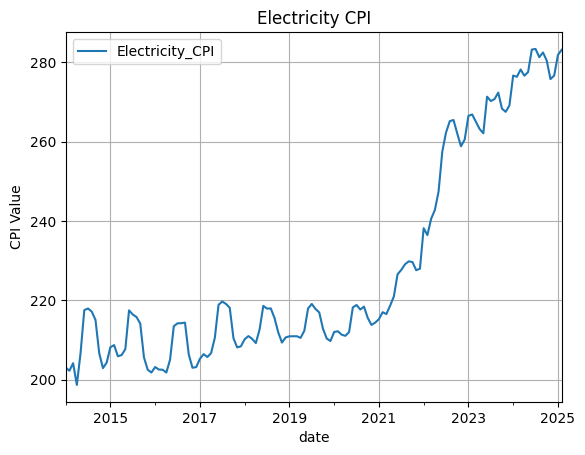

In [5]:
# THERE ARE MULTIPLE WAYS OF SAVING THE VARIOUS FIELDS FROM THE API. A SIMPLE LINE CHART OF PHARMA CPI.

series_data = json_data['Results']['series'][0]['data']
df = pd.DataFrame(series_data)
df['value'] = df['value'].astype(float)
df['date'] = pd.to_datetime(df['year'] + '-' + df['period'].str[1:] + '-01')
df = df[['date', 'value']].sort_values('date').reset_index(drop=True)
df.set_index('date', inplace=True)
df.rename(columns={'value': 'Electricity_CPI'}, inplace=True)

# Plot
df.plot(title='Electricity CPI')
plt.ylabel('CPI Value')
plt.grid(True)
plt.show()

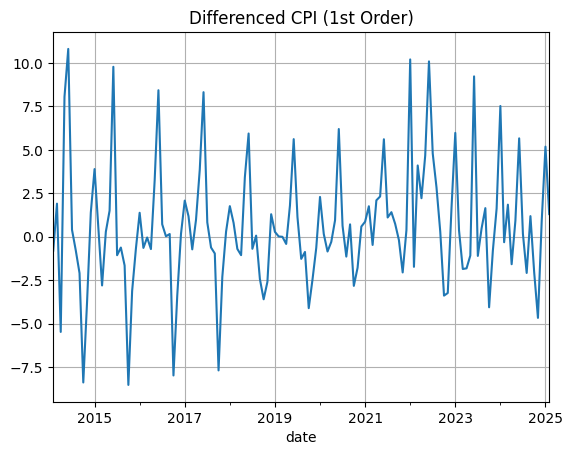

In [6]:
# THE FIRST DIFFERENCING - WHAT I AM LOOKING FOR IS A FLAT MEAN AND VARIANCE OVER TIME. NO CLEAR TRENDS OR SEASONALITY.
# No Trend: The data fluctuates around a relatively constant mean.
# Constant Variance: The ups and downs should be roughly the same size over time.
# Random Noise Appearance: It looks more like a flat, unpredictable series — no obvious patterns.
# ADF Test p-value < 0.05: Statistically confirms stationarity.
# IF FINANCIAL DATA, RULE OF THUMB IS THAT THE DATA ALWAYS NEEDS TO BE DIFFERENCED AT LEAST ONCE. CPI IS THAT.

ts = df['Electricity_CPI']
ts_diff = ts.diff().dropna()

ts_diff.plot(title='Differenced CPI (1st Order)')
plt.grid(True)
plt.show()

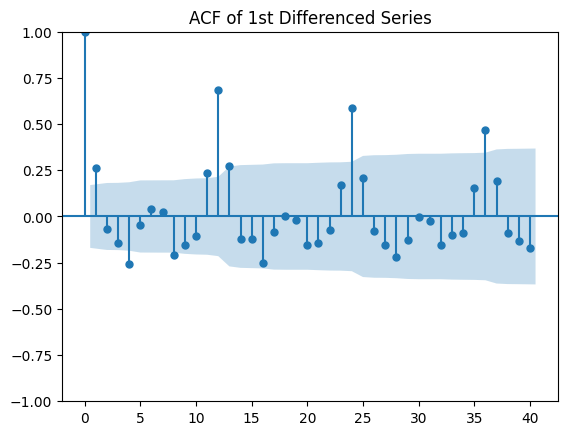

In [7]:
#ACF PLOT AFTER THE 1ST DIFFERENCED SERIES
plot_acf(ts_diff, lags=40)
plt.title("ACF of 1st Differenced Series")
plt.show()

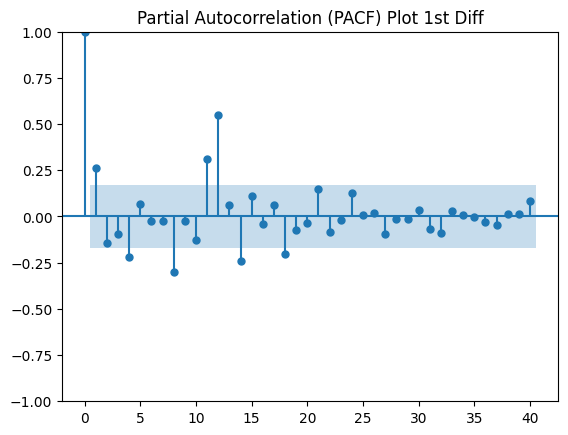

In [8]:
# PACF PLOT AFTER THE 1ST DIFFERENCED SERIES
plot_pacf(ts_diff, lags=40, method='ywm')
plt.title("Partial Autocorrelation (PACF) Plot 1st Diff")
plt.show()

In [9]:
# ADF TEST OUTPUT
# P-VALUE >0.05 - FAIL TO REJECT NULL -> TIME SERIES IS NON STATIONARY
# P-VALUE <= 0.05 - REJECT NULL -> TIME SERIES IS STATIONARY

result = adfuller(ts_diff)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -1.9008342196238834
p-value: 0.3316687693035699


In [10]:
model = ARIMA(ts, order=(1, 1, 1))
model_fit = model.fit()

In [11]:
forecast_1_result = model_fit.get_forecast(steps=12)
forecast_1 = forecast_1_result.predicted_mean
conf_int = forecast_1_result.conf_int()
residuals = model_fit.resid

In [ ]:
# Ljung-Box Q Test
# A p-value greater than 0.05 (or 5%) suggests the residuals are random and independent, indicating the model is a good fit

In [12]:
# Perform Ljung-Box test (default lag is 10)
ljung_box_results = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(ljung_box_results)

     lb_stat  lb_pvalue
10  0.960886   0.999857


In [13]:
# lb_pvalue -> P-value → the most important part
# If p-value > 0.05 → residuals do NOT show autocorrelation → model looks good!
# If p-value < 0.05 → residuals still have autocorrelation → model may be missing something.

In [14]:
ljung_box_results = acorr_ljungbox(residuals, lags=range(1, 21), return_df=True)
print(ljung_box_results)

     lb_stat  lb_pvalue
1   0.002100   0.963446
2   0.013208   0.993418
3   0.212278   0.975583
4   0.412821   0.981414
5   0.554390   0.989996
6   0.555835   0.997091
7   0.564795   0.999173
8   0.601568   0.999732
9   0.934336   0.999575
10  0.960886   0.999857
11  0.964051   0.999958
12  1.184734   0.999964
13  1.184824   0.999989
14  1.215860   0.999996
15  1.222971   0.999999
16  1.223905   1.000000
17  1.452856   1.000000
18  1.506010   1.000000
19  1.508525   1.000000
20  1.608506   1.000000


In [15]:
last_date = ts.index[-1]
forecast_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq='MS')
forecast_1.index = forecast_index
conf_int.index = forecast_index

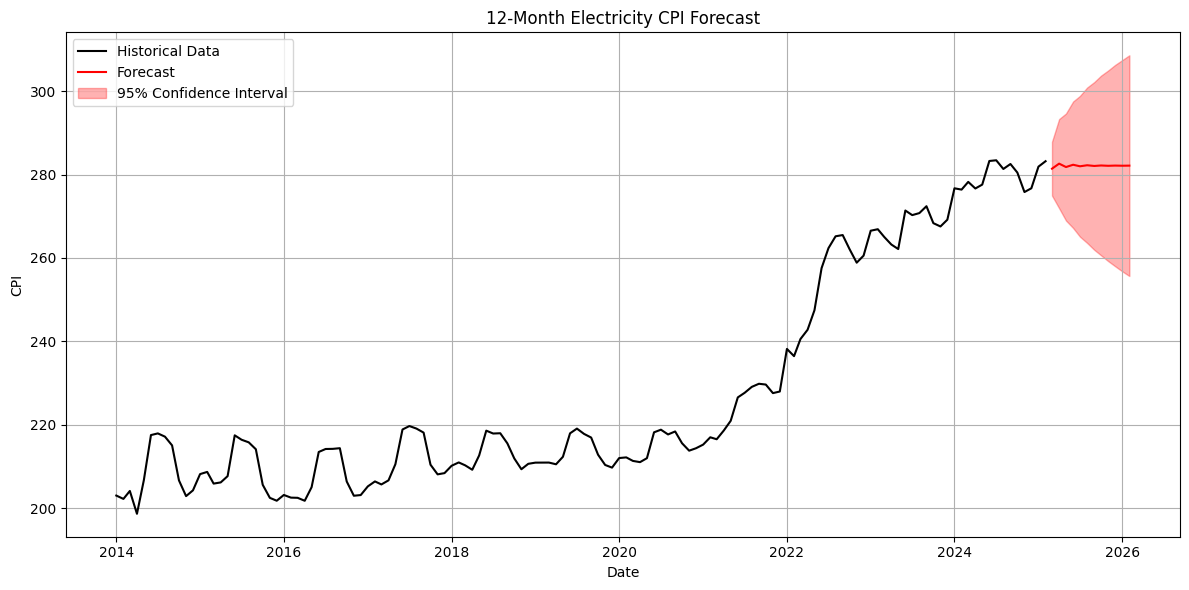

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(ts, label='Historical Data', color='black')
plt.plot(forecast_1, label='Forecast', color='red')
plt.fill_between(forecast_1.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1],
                 color='red', alpha=0.3, label='95% Confidence Interval')
plt.title('12-Month Electricity CPI Forecast')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
print("Forecast with 1st Differencing:")
print(forecast_1)

Forecast with 1st Differencing:
2025-03-01    281.402463
2025-04-01    282.609394
2025-05-01    281.796303
2025-06-01    282.344070
2025-07-01    281.975048
2025-08-01    282.223652
2025-09-01    282.056171
2025-10-01    282.169000
2025-11-01    282.092989
2025-12-01    282.144197
2026-01-01    282.109699
2026-02-01    282.132940
Freq: MS, Name: predicted_mean, dtype: float64


In [18]:
forecast_df = pd.DataFrame({
    'Forecast': forecast_1,
    'Lower CI (95%)': conf_int.iloc[:, 0],
    'Upper CI (95%)': conf_int.iloc[:, 1]
})



In [19]:
print(forecast_df)

              Forecast  Lower CI (95%)  Upper CI (95%)
2025-03-01  281.402463      274.947890      287.857035
2025-04-01  282.609394      271.925100      293.293688
2025-05-01  281.796303      268.953247      294.639358
2025-06-01  282.344070      267.180571      297.507568
2025-07-01  281.975048      265.088292      298.861803
2025-08-01  282.223652      263.598959      300.848345
2025-09-01  282.056171      261.951771      302.160571
2025-10-01  282.169000      260.617970      303.720031
2025-11-01  282.092989      259.230141      304.955837
2025-12-01  282.144197      258.013004      306.275390
2026-01-01  282.109699      256.791453      307.427944
2026-02-01  282.132940      255.669343      308.596536


In [ ]:
# MY CONCLUSION AFTER DOING THE FIRST DIFFERENCING. EVEN THOUGH THERE IS SOME WHITE NOISE IN THE ACF PLOT THE TREND LOOKS RELATIVELY STABLE AND STATIONARY AFTER 1 DIFF

In [ ]:
# THIS MY ATTEMPT TO GET MORE CONSERVATIVE AND EXPLORE IMPACT IF I DO A DOUBLE DIFFERENCING

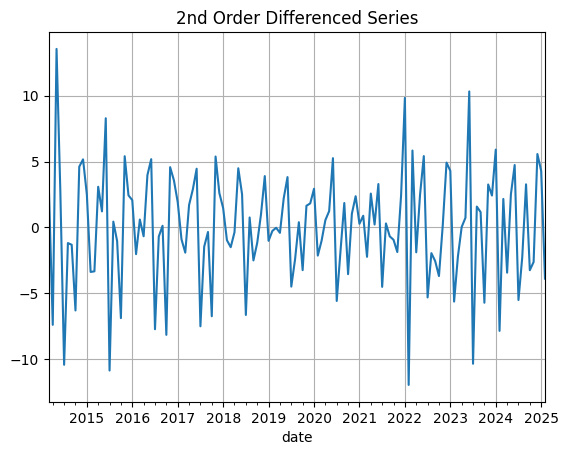

In [20]:
ts2 = df['Electricity_CPI']
ts_diff2 = ts_diff.diff().dropna()

ts_diff2.plot(title="2nd Order Differenced Series")
plt.grid(True)
plt.show()


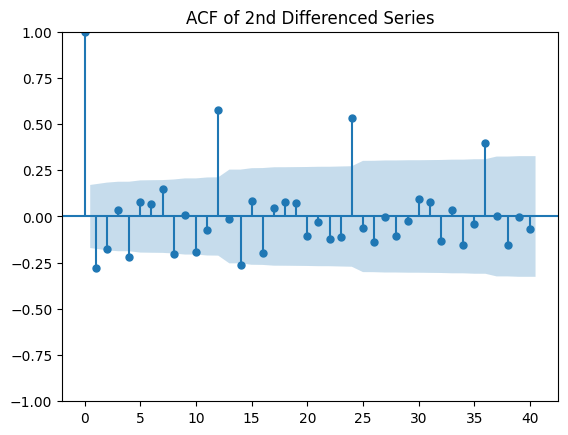

In [21]:
plot_acf(ts_diff2, lags=40)
plt.title("ACF of 2nd Differenced Series")
plt.show()

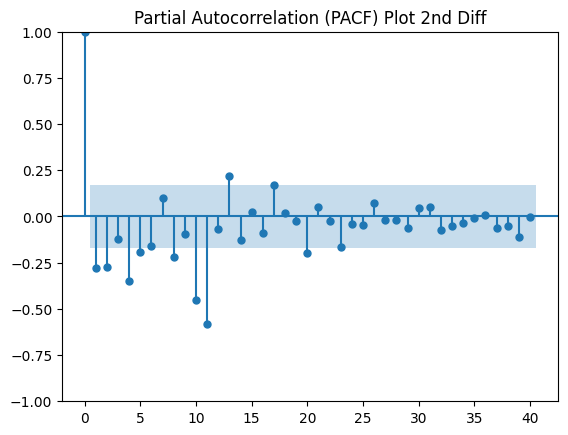

In [22]:
# PACF PLOT AFTER THE 1ST DIFFERENCED SERIES
plot_pacf(ts_diff2, lags=40, method='ywm')
plt.title("Partial Autocorrelation (PACF) Plot 2nd Diff")
plt.show()

In [23]:
# ADF TEST OUTPUT
# P-VALUE >0.05 - FAIL TO REJECT NULL -> TIME SERIES IS NON STATIONARY
# P-VALUE <= 0.05 - REJECT NULL -> TIME SERIES IS STATIONARY

result = adfuller(ts_diff2)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -4.396930503743072
p-value: 0.0003005675414781024


In [24]:
model = ARIMA(ts2, order=(1, 1, 1))
model_fit = model.fit()

In [25]:
forecast_2_result = model_fit.get_forecast(steps=12)
forecast_2 = forecast_2_result.predicted_mean
conf_int_2 = forecast_2_result.conf_int()
residuals_2 = model_fit.resid

In [ ]:
# Ljung-Box Q Test
# A p-value greater than 0.05 (or 5%) suggests the residuals are random and independent, indicating the model is a good fit

In [26]:
# Perform Ljung-Box test (default lag is 10)
ljung_box_results = acorr_ljungbox(residuals_2, lags=[10], return_df=True)
print(ljung_box_results)

     lb_stat  lb_pvalue
10  0.960886   0.999857


In [ ]:
# lb_pvalue -> P-value → the most important part
# If p-value > 0.05 → residuals do NOT show autocorrelation → model looks good!
# If p-value < 0.05 → residuals still have autocorrelation → model may be missing something.

In [27]:
ljung_box_results = acorr_ljungbox(residuals_2, lags=range(1, 21), return_df=True)
print(ljung_box_results)

     lb_stat  lb_pvalue
1   0.002100   0.963446
2   0.013208   0.993418
3   0.212278   0.975583
4   0.412821   0.981414
5   0.554390   0.989996
6   0.555835   0.997091
7   0.564795   0.999173
8   0.601568   0.999732
9   0.934336   0.999575
10  0.960886   0.999857
11  0.964051   0.999958
12  1.184734   0.999964
13  1.184824   0.999989
14  1.215860   0.999996
15  1.222971   0.999999
16  1.223905   1.000000
17  1.452856   1.000000
18  1.506010   1.000000
19  1.508525   1.000000
20  1.608506   1.000000


In [28]:
last_date_V2 = ts2.index[-1]
forecast_index_2 = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq='MS')
forecast_2.index = forecast_index_2
conf_int_2.index_2 = forecast_index_2

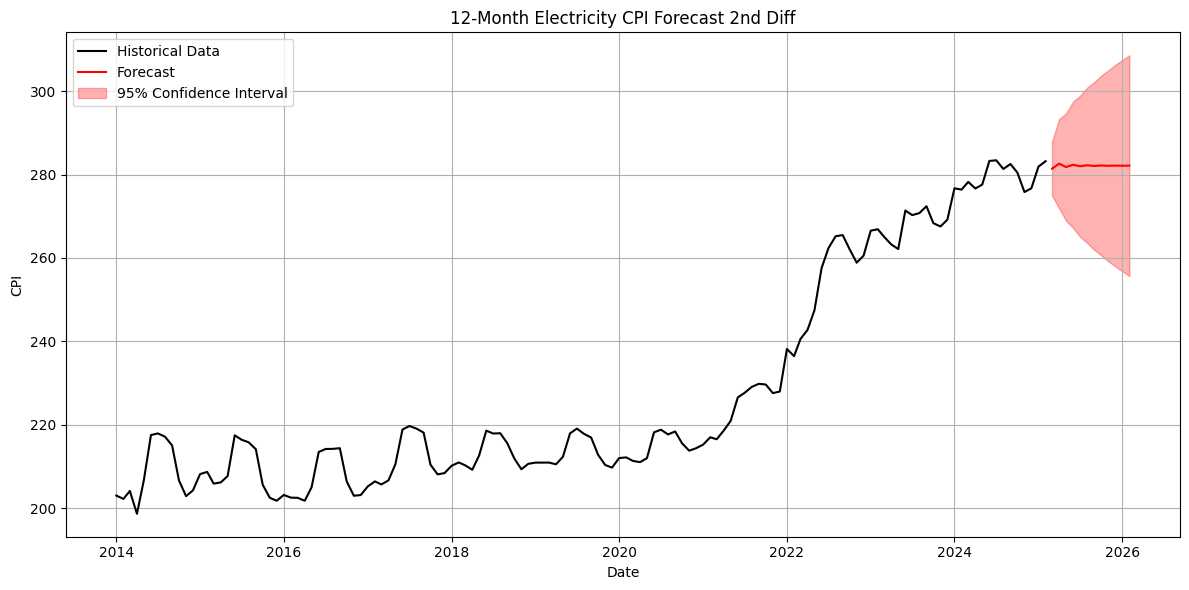

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(ts, label='Historical Data', color='black')
plt.plot(forecast_2, label='Forecast', color='red')
plt.fill_between(forecast_2.index, conf_int_2.iloc[:, 0], conf_int_2.iloc[:, 1],
                 color='red', alpha=0.3, label='95% Confidence Interval')
plt.title('12-Month Electricity CPI Forecast 2nd Diff')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
print("Forecast with 2ND Differencing:")
print(forecast_2)

Forecast with 2ND Differencing:
2025-03-01    572.705975
2025-04-01    572.701922
2025-05-01    572.701531
2025-06-01    572.701493
2025-07-01    572.701490
2025-08-01    572.701489
2025-09-01    572.701489
2025-10-01    572.701489
2025-11-01    572.701489
2025-12-01    572.701489
2026-01-01    572.701489
2026-02-01    572.701489
Freq: MS, Name: predicted_mean, dtype: float64


In [ ]:
forecast_2_df = pd.DataFrame({
    'Forecast': forecast_2,
    'Lower CI (95%)': conf_int_2.iloc[:, 0],
    'Upper CI (95%)': conf_int_2.iloc[:, 1]
})

In [ ]:
print(forecast_2_df)

              Forecast  Lower CI (95%)  Upper CI (95%)
2025-03-01  572.705975      566.100253      579.311697
2025-04-01  572.701922      562.749379      582.654465
2025-05-01  572.701531      560.224300      585.178762
2025-06-01  572.701493      558.126620      587.276367
2025-07-01  572.701490      556.294664      589.108315
2025-08-01  572.701489      554.647626      590.755353
2025-09-01  572.701489      553.138765      592.264213
2025-10-01  572.701489      551.738227      593.664751
2025-11-01  572.701489      550.425571      594.977407
2025-12-01  572.701489      549.186075      596.216904
2026-01-01  572.701489      548.008719      597.394259
2026-02-01  572.701489      546.885001      598.517978
